# Final Project
# “Artificial Intelligence - Wind Power Generation Forecasting”

**Load libraries**

In [1]:
# Import all your libraries only in this cell
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Make Numpy printout easier to read
np.set_printoptions(precision=3, suppress=True)


In [2]:
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import datetime
from tensorboard.plugins.hparams import api as hp

**Load datasets**

In [3]:
## First way~~~ Kaggle API
## Connect to kaggle
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print("User uploade file '{name}' with length {length} bytes".format(name=fn,
        length = len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json
User uploade file 'kaggle.json' with length 66 bytes


In [4]:
#Check the files 
!kaggle competitions files aifpc2022

name                  size  creationDate         
-------------------  -----  -------------------  
test.csv             153KB  2022-04-13 13:53:44  
train.csv            836KB  2022-04-13 13:53:44  
sample_solution.csv   89KB  2022-04-13 13:53:44  


In [5]:
#download the dataset
!kaggle competitions download -c aifpc2022

  0% 0.00/280k [00:00<?, ?B/s]
100% 280k/280k [00:00<00:00, 26.4MB/s]


In [6]:
#unzip files
!7za e aifpc2022.zip "train.csv"
!7za e aifpc2022.zip "test.csv"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 286618 bytes (280 KiB)

Extracting archive: aifpc2022.zip
--
Path = aifpc2022.zip
Type = zip
Physical Size = 286618

  0%    Everything is Ok

Size:       855865
Compressed: 286618

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 286618 bytes (280 KiB)

Extracting archive: aifpc2022.zip
--
Path = aifpc2022.zip
Type = zip
Physical Size = 286618

  0%    Everything is Ok

Size:       157175
Compressed: 286618


In [7]:
# load files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### second way

In [142]:
#1 .- Download data from kaggle website
#2 .- Load data to drive.google.com
# connect goolge drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
#load dataset
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [144]:
dataset=train_df.copy()
dataset.tail()

,ID,Date,Time,Wind_Energy_1,Wind_Energy_2,Wind_Energy_3
25148,25149,12/31/2020,20:00,0.0,0.3,1.6
25149,25150,12/31/2020,21:00,0.0,0.0,1.2
25150,25151,12/31/2020,22:00,0.0,0.4,2.1
25151,25152,12/31/2020,23:00,0.0,0.0,2.2
25152,25153,12/31/2020,24:00:00,0.0,0.0,2.6


**Data cleaning**

In [15]:
dataset.isna().sum()

ID               0
Date             0
Time             0
Wind_Energy_1    0
Wind_Energy_2    0
Wind_Energy_3    0
dtype: int64

In [16]:
dataset=dataset.dropna()

**preprocess** **data**



In [22]:
dataset['Month'] = dataset.Date.str.split('/').str[0].astype(float)
dataset['Days'] = dataset.Date.str.split('/').str[1].astype(float)
dataset['Hour'] = dataset.Time.str.split(':').str[0].astype(float)

In [23]:
dataset.drop(columns=['Date', 'Time', 'ID'], inplace=True )
dataset.tail()

,Wind_Energy_1,Wind_Energy_2,Wind_Energy_3,Month,Days,Hour
25148,0.0,0.3,1.6,12.0,31.0,20.0
25149,0.0,0.0,1.2,12.0,31.0,21.0
25150,0.0,0.4,2.1,12.0,31.0,22.0
25151,0.0,0.0,2.2,12.0,31.0,23.0
25152,0.0,0.0,2.6,12.0,31.0,24.0


In [79]:
## Split features
train_features = dataset.copy()

train_labels = train_features[['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3']].copy()
train_features = train_features.drop(['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3'],
                                     axis = 1)



**Normalization**

In [80]:
dataset.describe().transpose()[['mean','std']]


,mean,std
Wind_Energy_1,15.398925,18.931922
Wind_Energy_2,8.536261,9.958963
Wind_Energy_3,12.075927,11.549401
Month,6.758399,3.339400
Days,15.834016,8.803905
Hour,12.500457,6.922566


In [81]:
#The first step is to create the norm layer
normalizer = tf.keras.layers.Normalization(axis=-1)

In [82]:
#fit the preprocessing layer
normalizer.adapt(np.array(train_features))


In [83]:
print(normalizer.mean.numpy())

[[ 6.758 15.834 12.5  ]]


In [145]:
first = np.array(train_features[:1])

with np.printoptions(precision =2, suppress = True):
  print('First example: ',first)
  print()
  print('Normalized: ', normalizer(first).numpy())

First example:  [[ 2. 17. 24.]]

Normalized:  [[-1.42  0.13  1.66]]


**Descriptive statistics**

**Data visualizations**

**Split-out validation dataset**

**Deep Learning** 
**+ Graph results**

**Linear regression with one variable**

In [91]:
hour = np.array(train_features['Hour'])
hour_normalizer = layers.Normalization(input_shape=[1,], axis = None)
hour_normalizer. adapt(hour)


In [92]:
hour_model = tf.keras.Sequential([
hour_normalizer,
layers.Dense(units=3)
])
hour_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 3)                 6         
                                                                 
Total params: 9
Trainable params: 6
Non-trainable params: 3
_________________________________________________________________


In [93]:
 hour_model.predict(hour[:10])


array([[-1.738,  1.673,  1.928],
       [ 1.738, -1.674, -1.928],
       [ 1.587, -1.528, -1.761],
       [ 1.436, -1.383, -1.593],
       [ 1.285, -1.237, -1.425],
       [ 1.134, -1.091, -1.258],
       [ 0.983, -0.946, -1.09 ],
       [ 0.831, -0.8  , -0.922],
       [ 0.68 , -0.655, -0.755],
       [ 0.529, -0.509, -0.587]], dtype=float32)

In [95]:
hour_model.compile(
optimizer = tf.optimizers.Adam(learning_rate=0.1),
loss = 'mean_absolute_error')


In [96]:
 log_dir = "logs/fit/LR_one_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
log_dir=log_dir, histogram_freq = 1
)
hparams_callback = hp.KerasCallback(log_dir, {
'num_linear_units': 3,
})

In [97]:
%%time
history = hour_model.fit(
train_features['Hour'],#X
train_labels, #Y
epochs = 100,
#logging
verbose = 1,
# Calculate validation set based on training data
validation_split = 0.2,
callbacks=[tensorboard_callback,hparams_callback]
)

Epoch 1/100
629/629 [==============================] - 3s 3ms/step - loss: 10.9723 - val_loss: 10.4269
Epoch 2/100
629/629 [==============================] - 1s 2ms/step - loss: 10.9054 - val_loss: 10.4405
Epoch 3/100
629/629 [==============================] - 1s 2ms/step - loss: 10.9065 - val_loss: 10.4708
Epoch 4/100
629/629 [==============================] - 1s 2ms/step - loss: 10.9059 - val_loss: 10.4296
Epoch 5/100
629/629 [==============================] - 1s 2ms/step - loss: 10.9025 - val_loss: 10.4131
Epoch 6/100
629/629 [==============================] - 1s 2ms/step - loss: 10.9058 - val_loss: 10.4629
Epoch 7/100
629/629 [==============================] - 1s 2ms/step - loss: 10.9066 - val_loss: 10.4558
Epoch 8/100
629/629 [==============================] - 1s 2ms/step - loss: 10.9034 - val_loss: 10.4081
Epoch 9/100
629/629 [==============================] - 1s 2ms/step - loss: 10.9030 - val_loss: 10.4458
Epoch 10/100
629/629 [==============================] - 1s 2ms/step - los

In [98]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,10.902959,10.448644,95
96,10.905918,10.449553,96
97,10.904243,10.430017,97
98,10.907520,10.443121,98
99,10.906438,10.437822,99


In [100]:
def plot_loss(history):
   plt.plot(history.history['loss'], label='loss')
   plt.plot(history.history['val_loss'], label='val_loss')
   plt.xlabel('Epoch')
   plt.ylabel('Error [kWh]')
   plt.legend()
   plt.grid(True)

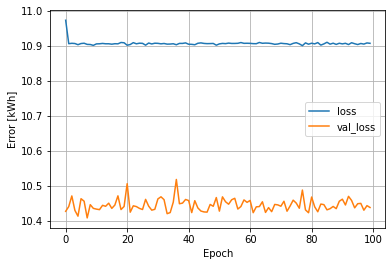

In [101]:
 plot_loss(history)


In [146]:
##Prepare test set
test_df['Month'] = test_df.Date.str.split('/').str[0].astype(float)
test_df['Days'] = test_df.Date.str.split('/').str[1].astype(float)
test_df['Hour'] = test_df.Time.str.split(':').str[0].astype(float)
test_df = test_df.drop(columns=['Date','Time'])
test_df.tail()



,ID,Month,Days,Hour
6979,32133,10.0,18.0,20.0
6980,32134,10.0,18.0,21.0
6981,32135,10.0,18.0,22.0
6982,32136,10.0,18.0,23.0
6983,32137,10.0,18.0,24.0


In [109]:
test_features = test_df.copy()
LR_One_df = hour_model.predict(test_features['Hour'])

In [150]:
result = pd.DataFrame(LR_One_df,
columns =␣
,→['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3'],
index = test_df['ID'])
result.to_csv('/content/drive/MyDrive/Colab Notebooks/ai_dataset/solution_lr.
,→csv')

SyntaxError: ignored

In [151]:
!tensorboard dev upload --logdir ./logs 
  --name "First DL model" \
  --descrption "Training results" \
  --one_shot \

IndentationError: ignored

In [137]:
## Generate the test.cvs results and submitted to kaggle.com